In [1]:
## Step 1: Store 1 year of data for every necessary tag

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from ecotools.pi_client import pi_client
import requests
import seaborn as sns 
from sklearn.cluster import KMeans
import os
os.chdir(r"/Users/danielsoriano/Desktop/ds/kBtu Baselines")

import warnings
warnings.filterwarnings('ignore')
#print(mnv.version)  # Last updated for mnv v2.0.1
from dateutil.relativedelta import relativedelta
from matplotlib import style
style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split 
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.metrics import r2_score
import math
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor
#import auto_run_ele_tag
import logging
import ecotools.auto

/var/folders/8x/9brmr5z936dchlptv7w2kjzr0000gn/T/ipykernel_22409/2985232912.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import pandas as pd
import numpy as np
from ecotools.pi_client import pi_client
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
pc = pi_client(username= r'dbsorian')

def main():
    from datetime import datetime, timedelta
    #pred_start = pd.to_datetime(datetime.now().strftime('%Y-%m-%d %H:00:00')) - timedelta(days=1)
    #pred_end = datetime.now().strftime('%Y-%m-%d %H:00:00')
    pc = pi_client(username= r'dbsorian')

Connecting to PI API using 'basic authentication'


In [3]:
# Splits data into a training set
def split_data(X, y, test_size=0.2, shuffle=False, random_state=42):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=shuffle, random_state=random_state)
    return X_train, X_val, y_train, y_val

In [4]:
data_name = pc.search_by_point("*ChilledWater*demand_kBtu")

In [5]:
def data_manipu(data_name, df, temp):
    # get the data and rename columns
    df["Temp"] = temp
    df['cdd'] = 0
    df.loc[df.Temp > 65, 'cdd'] = df.loc[df.Temp > 65, 'Temp'] - 65
    df['hdd'] = 0
    df.loc[df.Temp < 65, 'hdd'] = 65 - df.loc[df.Temp < 65, 'Temp']
    df['cdd2'] = df.cdd**2
    df['hdd2'] = df.hdd**2
    df["Hour"] = df.index.hour
    df["Month"] = df.index.month
    df["DOW"] = df.index.dayofweek
    df['covid'] = 0
    df.loc["2020-03-17":"2021-09-28", 'covid'] = 1
    
    # specifiy the rolling std method
#     df = df.dropna()
#     r = df.rolling(window=20)  # Create a rolling object (no computation yet)
#     mps1 = r.mean() + 3 * r.std()  # Combine a mean and stdev on that object
#     mps2 = r.mean() - 3 * r.std()
#     mps3 = r.mean() + 3 * r.std()
#     mps4 = r.mean() - 3 * r.std()
    
#     # identify outliers
#     cc1=df[df[data_name] > mps1[data_name]]
#     cc2= df[df[data_name] < mps2[data_name]]
#     dd1=df[df.Temp > mps3.Temp]
#     dd2=df[df.Temp < mps4.Temp]

#     # remove outliers
#     index_names_1 = cc1.index_names_1 = cc1[data_name].index
#     index_names_2 = cc2.index_names_2 = cc2[data_name].index
#     index_names_3 = dd1.Temp.index
#     index_names_4 = dd2.Temp.index
#     final_index_name = index_names_1.union(index_names_2).union(index_names_3).union(index_names_4)
#     df.drop(final_index_name, inplace=True)
    
    x = df.loc[:, ['Temp','cdd','hdd','cdd2','hdd2','Hour','Month','DOW','covid']]
    y = df[data_name]
    
    # split the cleaned data
    X_train, X_val, y_train, y_val = split_data(x,y)
    
    return X_train, X_val, y_train, y_val

In [6]:
    # Pull out all electricity tags data and weather
tags = pc.search_by_point("*ChilledWater*demand_kBtu")
tags.append("aiTIT4045")

start = datetime.now() - timedelta(days=365)
end = datetime.now()
interval = '1h'    
calc = 'summary'  
chunk_size = 10

df = pc.get_stream_by_point(tags, start=start, end=end, 
                            _convert_cols='numeric', calculation=calc, 
                            interval=interval, _chunk_size=chunk_size)
df


12:07:57: Sending API request... Chunk 1 of 10
12:08:03: Response recieved for 10 tags! (6.13)
12:08:05: Sending API request... Chunk 2 of 10
12:08:14: Response recieved for 10 tags! (8.94)
12:08:16: Sending API request... Chunk 3 of 10
12:08:24: Response recieved for 10 tags! (7.46)
12:08:26: Sending API request... Chunk 4 of 10
12:08:34: Response recieved for 10 tags! (8.34)
12:08:37: Sending API request... Chunk 5 of 10
12:08:42: Response recieved for 10 tags! (5.83)
12:08:44: Sending API request... Chunk 6 of 10
12:09:02: Response recieved for 10 tags! (17.33)
12:09:04: Sending API request... Chunk 7 of 10
12:09:08: Response recieved for 10 tags! (4.49)
12:09:11: Sending API request... Chunk 8 of 10
12:09:14: Response recieved for 10 tags! (3.1)
12:09:16: Sending API request... Chunk 9 of 10
12:09:20: Response recieved for 10 tags! (4.19)
12:09:22: Sending API request... Chunk 10 of 10
12:09:27: Response recieved for 4 tags! (4.91)


,AcademicSurge_ChilledWater_Demand_kBtu,Administrative_Support_Building_ChilledWater_Demand_kBtu,ARCPavilion_ChilledWater_Demand_kBtu,ARC_ChilledWater_Demand_kBtu,ArtStudio_ChilledWater_Demand_kBtu,Art_Music_Wright_ChilledWater_Demand_kBtu,Asmundson_ChilledWater_Demand_kBtu,Bainer_ChilledWater_Demand_kBtu,Briggs_ChilledWater_Demand_kBtu,California_ChilledWater_Demand_kBtu,...,VMIF_ChilledWater_Demand_kBtu,VMSSAC_ChilledWater_Demand_kBtu,VMTH_ChilledWater_Demand_kBtu,Walker_Hall_ChilledWater_Demand_kBtu,WatershedResearch_ChilledWater_Demand_kBtu,Wellman_Kerr_ChilledWater_Demand_kBtu,WHNRC_ChilledWater_Demand_kBtu,Wickson_ChilledWater_Demand_kBtu,Young_ChilledWater_Demand_kBtu,aiTIT4045
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-07-12 12:07:57.549283,1976.245089,866.408145,2031.351364,3715.018071,83.396245,1606.409621,669.358200,2682.101594,5931.567617,212.453492,...,791.821645,0.000000,2603.693601,422.637654,575.352367,0.000000,1748.169199,1496.000000,1152.435225,88.926674
2022-07-12 13:07:57.549283,2200.940866,927.719342,1919.044270,3973.470806,92.071323,1877.774419,686.794461,2899.202174,6301.756664,220.526155,...,840.080352,0.000000,2735.274564,377.515585,636.551654,0.000000,1897.299547,1588.460011,1205.596058,92.171306
2022-07-12 14:07:57.549283,2417.371662,988.862277,2113.056191,4394.689769,101.840204,2416.733805,755.441916,2926.808136,6900.940756,240.192143,...,914.130023,0.000000,3053.715624,451.302895,680.995319,0.000000,2054.151934,1710.250781,1319.160294,94.970474
2022-07-12 15:07:57.549283,2464.709028,914.760235,2104.922545,4515.759440,105.192096,1983.592457,795.973231,3035.414529,6931.144610,255.752066,...,934.762541,0.000000,3116.149774,533.847170,706.687546,0.000000,2134.368603,1746.767375,1368.236938,95.890789
2022-07-12 16:07:57.549283,2504.700854,895.265258,2292.351221,4614.552456,112.194703,2163.721209,767.847004,3241.922228,6905.145876,257.318794,...,1010.227062,0.000000,3089.655582,475.576979,689.354694,0.000000,2136.380256,1786.492987,1368.839799,97.482094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-12 07:07:57.549283,0.000000,734.000000,0.000000,364.853518,0.000000,539.433029,6.164247,829.624299,584.065616,0.000000,...,68.862384,213.596239,601.671788,94.633348,161.338566,31.249829,938.906864,521.000000,630.991080,67.311847
2023-07-12 08:07:57.549283,164.632792,734.000000,1342.030452,1206.679080,0.000000,893.679882,180.043471,1041.875890,1353.972902,0.000000,...,230.718957,327.785083,887.218642,175.150641,267.841249,107.170705,1142.258425,654.790883,757.484357,71.052558
2023-07-12 09:07:57.549283,873.201338,734.000000,1031.281541,2270.626261,15.150532,743.810167,433.447560,1254.173177,2375.802152,31.285914,...,422.919309,427.884751,1628.877852,272.961633,351.630946,206.097056,1405.802853,857.744177,896.703914,75.962096


In [7]:
# Drop all NaN columns
df2 = df.dropna(axis=1,how='all')
df2 = df2.ffill()
data2_name = df2.iloc[:,:-1].columns
data2_name
df2

,AcademicSurge_ChilledWater_Demand_kBtu,Administrative_Support_Building_ChilledWater_Demand_kBtu,ARCPavilion_ChilledWater_Demand_kBtu,ARC_ChilledWater_Demand_kBtu,ArtStudio_ChilledWater_Demand_kBtu,Art_Music_Wright_ChilledWater_Demand_kBtu,Asmundson_ChilledWater_Demand_kBtu,Bainer_ChilledWater_Demand_kBtu,Briggs_ChilledWater_Demand_kBtu,California_ChilledWater_Demand_kBtu,...,VMIF_ChilledWater_Demand_kBtu,VMSSAC_ChilledWater_Demand_kBtu,VMTH_ChilledWater_Demand_kBtu,Walker_Hall_ChilledWater_Demand_kBtu,WatershedResearch_ChilledWater_Demand_kBtu,Wellman_Kerr_ChilledWater_Demand_kBtu,WHNRC_ChilledWater_Demand_kBtu,Wickson_ChilledWater_Demand_kBtu,Young_ChilledWater_Demand_kBtu,aiTIT4045
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-07-12 12:07:57.549283,1976.245089,866.408145,2031.351364,3715.018071,83.396245,1606.409621,669.358200,2682.101594,5931.567617,212.453492,...,791.821645,0.000000,2603.693601,422.637654,575.352367,0.000000,1748.169199,1496.000000,1152.435225,88.926674
2022-07-12 13:07:57.549283,2200.940866,927.719342,1919.044270,3973.470806,92.071323,1877.774419,686.794461,2899.202174,6301.756664,220.526155,...,840.080352,0.000000,2735.274564,377.515585,636.551654,0.000000,1897.299547,1588.460011,1205.596058,92.171306
2022-07-12 14:07:57.549283,2417.371662,988.862277,2113.056191,4394.689769,101.840204,2416.733805,755.441916,2926.808136,6900.940756,240.192143,...,914.130023,0.000000,3053.715624,451.302895,680.995319,0.000000,2054.151934,1710.250781,1319.160294,94.970474
2022-07-12 15:07:57.549283,2464.709028,914.760235,2104.922545,4515.759440,105.192096,1983.592457,795.973231,3035.414529,6931.144610,255.752066,...,934.762541,0.000000,3116.149774,533.847170,706.687546,0.000000,2134.368603,1746.767375,1368.236938,95.890789
2022-07-12 16:07:57.549283,2504.700854,895.265258,2292.351221,4614.552456,112.194703,2163.721209,767.847004,3241.922228,6905.145876,257.318794,...,1010.227062,0.000000,3089.655582,475.576979,689.354694,0.000000,2136.380256,1786.492987,1368.839799,97.482094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-12 07:07:57.549283,0.000000,734.000000,0.000000,364.853518,0.000000,539.433029,6.164247,829.624299,584.065616,0.000000,...,68.862384,213.596239,601.671788,94.633348,161.338566,31.249829,938.906864,521.000000,630.991080,67.311847
2023-07-12 08:07:57.549283,164.632792,734.000000,1342.030452,1206.679080,0.000000,893.679882,180.043471,1041.875890,1353.972902,0.000000,...,230.718957,327.785083,887.218642,175.150641,267.841249,107.170705,1142.258425,654.790883,757.484357,71.052558
2023-07-12 09:07:57.549283,873.201338,734.000000,1031.281541,2270.626261,15.150532,743.810167,433.447560,1254.173177,2375.802152,31.285914,...,422.919309,427.884751,1628.877852,272.961633,351.630946,206.097056,1405.802853,857.744177,896.703914,75.962096


In [8]:
for i in range(df2.shape[1]):
    df = df2
    temp = df.aiTIT4045

    df["Temp"] = temp
    df['cdd'] = 0
    df.loc[df.Temp > 65, 'cdd'] = df.loc[df.Temp > 65, 'Temp'] - 65
    df['hdd'] = 0
    df.loc[df.Temp < 65, 'hdd'] = 65 - df.loc[df.Temp < 65, 'Temp']
    df['cdd2'] = df.cdd**2
    df['hdd2'] = df.hdd**2
    df["Hour"] = df.index.hour
    df["Month"] = df.index.month
    df["DOW"] = df.index.dayofweek
    df['covid'] = 0
    df.loc["2020-03-17":"2021-09-28", 'covid'] = 1

        # specifiy the rolling std method
#     df = df.dropna()
#     r = df2.rolling(window=20)  # Create a rolling object (no computation yet)
#     mps1 = r.mean() + 3 * r.std()  # Combine a mean and stdev on that object
#     mps2 = r.mean() - 3 * r.std()
#     mps3 = r.mean() + 3 * r.std()
#     mps4 = r.mean() - 3 * r.std()

        # identify outliers
#     cc1=df2[df2[data2_name[i]] > mps1[data2_name[i]]]
#     cc2= df2[df2[data2_name[i]] < mps2[data2_name[i]]]
#     dd1=df2[df2.Temp > mps3.Temp]
#     dd2=df2[df2.Temp < mps4.Temp]

#         # remove outliers
#     index_names_1 = cc1.index_names_1 = cc1[data2_name[i]].index
#     index_names_2 = cc2.index_names_2 = cc2[data2_name[i]].index
#     index_names_3 = dd1.Temp.index
#     index_names_4 = dd2.Temp.index
#     final_index_name = index_names_1.union(index_names_2).union(index_names_3).union(index_names_4)
#     df.drop(final_index_name, inplace=True)

    x = df.loc[:, ['Temp','cdd','hdd','cdd2','hdd2','Hour','Month','DOW','covid']]
    y = df[data2_name]

        # split the cleaned data
    X_train, X_val, y_train, y_val = split_data(x,y)
# print(X_train)
# print(X_val)
# print(y_train)
# print(y_val)

In [9]:
    # scale the trained data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
df2

,AcademicSurge_ChilledWater_Demand_kBtu,Administrative_Support_Building_ChilledWater_Demand_kBtu,ARCPavilion_ChilledWater_Demand_kBtu,ARC_ChilledWater_Demand_kBtu,ArtStudio_ChilledWater_Demand_kBtu,Art_Music_Wright_ChilledWater_Demand_kBtu,Asmundson_ChilledWater_Demand_kBtu,Bainer_ChilledWater_Demand_kBtu,Briggs_ChilledWater_Demand_kBtu,California_ChilledWater_Demand_kBtu,...,aiTIT4045,Temp,cdd,hdd,cdd2,hdd2,Hour,Month,DOW,covid
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-07-12 12:07:57.549283,1976.245089,866.408145,2031.351364,3715.018071,83.396245,1606.409621,669.358200,2682.101594,5931.567617,212.453492,...,88.926674,88.926674,23.926674,0.0,572.485713,0.0,12,7,1,0
2022-07-12 13:07:57.549283,2200.940866,927.719342,1919.044270,3973.470806,92.071323,1877.774419,686.794461,2899.202174,6301.756664,220.526155,...,92.171306,92.171306,27.171306,0.0,738.279892,0.0,13,7,1,0
2022-07-12 14:07:57.549283,2417.371662,988.862277,2113.056191,4394.689769,101.840204,2416.733805,755.441916,2926.808136,6900.940756,240.192143,...,94.970474,94.970474,29.970474,0.0,898.229309,0.0,14,7,1,0
2022-07-12 15:07:57.549283,2464.709028,914.760235,2104.922545,4515.759440,105.192096,1983.592457,795.973231,3035.414529,6931.144610,255.752066,...,95.890789,95.890789,30.890789,0.0,954.240827,0.0,15,7,1,0
2022-07-12 16:07:57.549283,2504.700854,895.265258,2292.351221,4614.552456,112.194703,2163.721209,767.847004,3241.922228,6905.145876,257.318794,...,97.482094,97.482094,32.482094,0.0,1055.086402,0.0,16,7,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-12 07:07:57.549283,0.000000,734.000000,0.000000,364.853518,0.000000,539.433029,6.164247,829.624299,584.065616,0.000000,...,67.311847,67.311847,2.311847,0.0,5.344637,0.0,7,7,2,0
2023-07-12 08:07:57.549283,164.632792,734.000000,1342.030452,1206.679080,0.000000,893.679882,180.043471,1041.875890,1353.972902,0.000000,...,71.052558,71.052558,6.052558,0.0,36.633459,0.0,8,7,2,0
2023-07-12 09:07:57.549283,873.201338,734.000000,1031.281541,2270.626261,15.150532,743.810167,433.447560,1254.173177,2375.802152,31.285914,...,75.962096,75.962096,10.962096,0.0,120.167539,0.0,9,7,2,0


In [10]:
# test = df2.loc[:,["Month", "aiTIT4045", "Temp", "cdd", "hdd", "cdd2", "hdd2", "DOW"]]
# test.iloc[-670:-650, :]
# test.iloc[-30:-10, :]

In [11]:
# test.iloc[-8741:-8721,:]

In [12]:
def plotplot2(method, X_train, X_val, y_train, y_val):
    
    # set up stats calculation
    r2_train = r2_score(y_train, method.predict(X_train))
    r2_val = r2_score(y_val, method.predict(X_val))
    rmse_train = math.sqrt(mean_squared_error(y_train, method.predict(X_train)))
    rmse_val = math.sqrt(mean_squared_error(y_val, method.predict(X_val)))
    mae_train = np.median((method.predict(X_train) - y_train.values))
    mae_val = np.median(method.predict(X_val) - y_val.values)
    cvrmse_train = rmse_train/(np.max(method.predict(X_train))-np.min(method.predict(X_train))/2)
    cvrmse_val = rmse_val/(np.max(method.predict(X_val))-np.min((method.predict(X_val))/2))
    return cvrmse_val, r2_val


In [13]:
newdf = pd.DataFrame()
temperature = pd.DataFrame(df2.aiTIT4045)

# create a prediction for all tags to put in newdf
for i in range(len(df2.iloc[:,:-10].columns)):
#for i in range(5):

    X_train, X_val, y_train, y_val = data_manipu(df2.iloc[:,i].name, df2, temperature)
            # scale the data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    gbt = RandomForestRegressor(random_state=42)
    gbt_param_list = {"max_depth":[5,10],
                      "n_estimators":[100,1000]
                     }
            #using gradient boosting method
    gs_gbt = HalvingRandomSearchCV(gbt, gbt_param_list,cv = 3, factor=3, min_resources='smallest')
    gs_gbt.fit(X_train_scaled, y_train)
            # validation cvrmse > 0.3and r2 <0.6 check, if not, not run the rest and put the tag name into the list
    cvrmse_val, r2_val = plotplot2(method = gs_gbt,X_train = X_train_scaled, X_val = X_val_scaled,
                                   y_train = y_train, y_val= y_val)
            # print() 
            # print(round(cvrmse_val,2), round(r2_val,2))
            # print()

    start = datetime.now() - timedelta(days=365)
    end = datetime.now()
    x_predict = pc.get_stream_by_point('aiTIT4045',  start = start,
                                       end = end, calculation=calc,
                                       interval=interval,
                                       _chunk_size=chunk_size)
    x_predict.rename(columns = {'aiTIT4045':'Temp'}, inplace=True)
    x_predict['cdd'] = 0
    x_predict.loc[x_predict.Temp > 65, 'cdd'] = x_predict.loc[x_predict.Temp > 65, 'Temp'] - 65
    x_predict['hdd'] = 0
    x_predict.loc[x_predict.Temp < 65, 'hdd'] = 65 - x_predict.loc[x_predict.Temp < 65, 'Temp']
    x_predict['cdd2'] = x_predict.cdd**2
    x_predict['hdd2'] = x_predict.hdd**2
    x_predict["Hour"] = x_predict.index.hour
    x_predict["Month"] = x_predict.index.month
    x_predict["DOW"] = x_predict.index.dayofweek
    x_predict['covid'] = 0
            # x_predict.loc["2020-03-17":"2021-09-28", 'covid'] = 1
    x_predict = x_predict.dropna()
    x_predict_scaled = scaler.transform(x_predict)

            # final check
        #     df_check = pc.get_stream_by_point(data_name, start=pred_start, 
        #                                            end=pred_end, calculation=calculation,
        #                                            interval=interval, 
        #                                           _chunk_size=chunk_size)

        #     # checking cvrmse and r2
    if cvrmse_val > 0.5:
        pred = np.nan
        newdf.insert(i, data2_name[i], pred)
        print(i+1, "out of", len(df2.iloc[:,:-10].columns))
        #print(pd.DataFrame(pred, index=x_predict.index, columns = [data_name[i]]))

    else:
        # put new predicted values in newdf
        pred = gs_gbt.predict(x_predict_scaled)
        newdf.insert(i, data2_name[i], pred)
        print(i+1, "out of", len(df2.iloc[:,:-10].columns))
        #print(pd.DataFrame(pred, index=x_predict.index, columns = [data_name[i]]))

12:46:05: Sending API request... Chunk 1 of 1
12:46:06: Response recieved for 1 tags! (0.84)
1 out of 93
12:46:26: Sending API request... Chunk 1 of 1
12:46:26: Response recieved for 1 tags! (0.44)
2 out of 93
12:46:46: Sending API request... Chunk 1 of 1
12:46:46: Response recieved for 1 tags! (0.43)
3 out of 93
12:46:55: Sending API request... Chunk 1 of 1
12:46:55: Response recieved for 1 tags! (0.37)
4 out of 93
12:47:04: Sending API request... Chunk 1 of 1
12:47:04: Response recieved for 1 tags! (0.38)
5 out of 93


In [14]:
newdf

,AcademicSurge_ChilledWater_Demand_kBtu,Administrative_Support_Building_ChilledWater_Demand_kBtu,ARCPavilion_ChilledWater_Demand_kBtu,ARC_ChilledWater_Demand_kBtu,ArtStudio_ChilledWater_Demand_kBtu
0,2324.612016,640.526191,1696.367157,3900.038764,95.345723
1,2543.855611,630.155613,1858.059505,4226.614912,107.538369
2,2493.169594,671.030983,1907.538663,4441.009867,108.649220
3,2498.356737,611.044921,1908.114845,4491.940681,111.073162
4,2460.244055,614.689311,1939.779968,4488.519401,110.674046
...,...,...,...,...,...
8726,352.497765,539.142656,666.157324,1039.327492,0.182206
8727,703.350698,585.879913,1105.486114,2209.418577,0.889238
8728,1157.773448,629.190371,971.343386,2729.451343,30.656104
8729,1636.946532,602.578050,1255.529170,3009.729725,53.424091


In [15]:
    # replace name for the new models
send_df = newdf.copy()
send_df.columns = send_df.columns.str.replace('ChilledWater_Demand_kBtu','Baseline_Modeled_ChilledWater')
send_df


# chunk_split = 24
# chunk = int(len(send_df)/chunk_split)

# i = 0
# while i < chunk_split:
#     pc.write_data_to_pi(send_df.iloc[chunk*i:chunk*(i+1), :], update_option='Replace', override='pinkdinosaur')
#     i += 1
    
#if __name__ == "__main__":
#    ecotools.auto.run_task(main, log_name='kbtu_model_ele', recipients=['dsimperiale@ucdavis.edu'])

,AcademicSurge_Baseline_Modeled_ChilledWater,Administrative_Support_Building_Baseline_Modeled_ChilledWater,ARCPavilion_Baseline_Modeled_ChilledWater,ARC_Baseline_Modeled_ChilledWater,ArtStudio_Baseline_Modeled_ChilledWater
0,2324.612016,640.526191,1696.367157,3900.038764,95.345723
1,2543.855611,630.155613,1858.059505,4226.614912,107.538369
2,2493.169594,671.030983,1907.538663,4441.009867,108.649220
3,2498.356737,611.044921,1908.114845,4491.940681,111.073162
4,2460.244055,614.689311,1939.779968,4488.519401,110.674046
...,...,...,...,...,...
8726,352.497765,539.142656,666.157324,1039.327492,0.182206
8727,703.350698,585.879913,1105.486114,2209.418577,0.889238
8728,1157.773448,629.190371,971.343386,2729.451343,30.656104
8729,1636.946532,602.578050,1255.529170,3009.729725,53.424091


In [20]:
#temp = df2["AcademicSurge_Electricity_Demand_kBtu"]
#print(temp.iloc[:-1,:])

temp = df2.iloc[28:,:]

#print(temp["ARCPavilion_Electricity_Demand_kBtu"])
#print(send_df["ARCPavilion_Baseline_Modeled_Electricity"])
#print(df2["ARCPavilion_Electricity_Demand_kBtu"])

print(temp["AcademicSurge_ChilledWater_Demand_kBtu"])
print(send_df["AcademicSurge_Baseline_Modeled_ChilledWater"])
temp

Timestamp
2022-07-13 16:07:57.549283    2202.756823
2022-07-13 17:07:57.549283    2058.069578
2022-07-13 18:07:57.549283    1752.201521
2022-07-13 19:07:57.549283    1319.135066
2022-07-13 20:07:57.549283     986.358769
                                 ...     
2023-07-12 07:07:57.549283       0.000000
2023-07-12 08:07:57.549283     164.632792
2023-07-12 09:07:57.549283     873.201338
2023-07-12 10:07:57.549283    1393.556257
2023-07-12 11:07:57.549283    1679.464894
Name: AcademicSurge_ChilledWater_Demand_kBtu, Length: 8731, dtype: float64
0       2324.612016
1       2543.855611
2       2493.169594
3       2498.356737
4       2460.244055
           ...     
8726     352.497765
8727     703.350698
8728    1157.773448
8729    1636.946532
8730    1884.911062
Name: AcademicSurge_Baseline_Modeled_ChilledWater, Length: 8731, dtype: float64


,AcademicSurge_ChilledWater_Demand_kBtu,Administrative_Support_Building_ChilledWater_Demand_kBtu,ARCPavilion_ChilledWater_Demand_kBtu,ARC_ChilledWater_Demand_kBtu,ArtStudio_ChilledWater_Demand_kBtu,Art_Music_Wright_ChilledWater_Demand_kBtu,Asmundson_ChilledWater_Demand_kBtu,Bainer_ChilledWater_Demand_kBtu,Briggs_ChilledWater_Demand_kBtu,California_ChilledWater_Demand_kBtu,...,aiTIT4045,Temp,cdd,hdd,cdd2,hdd2,Hour,Month,DOW,covid
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-07-13 16:07:57.549283,2202.756823,919.183662,1682.691454,3665.656168,97.299723,1467.540398,690.044220,2635.475070,5747.776951,204.481065,...,92.270668,92.270668,27.270668,0.0,743.689343,0.0,16,7,2,0
2022-07-13 17:07:57.549283,2058.069578,943.061197,1673.857035,3719.439307,94.813829,1585.152875,539.877145,2708.984683,5670.114337,181.240922,...,91.654725,91.654725,26.654725,0.0,710.474369,0.0,17,7,2,0
2022-07-13 18:07:57.549283,1752.201521,1072.392817,1595.026717,3541.031149,72.928500,209.591416,632.871143,2519.677153,4959.846217,134.319673,...,89.311312,89.311312,24.311312,0.0,591.039909,0.0,18,7,2,0
2022-07-13 19:07:57.549283,1319.135066,1061.734718,1787.790586,3094.806822,47.840287,0.000000,477.009878,2464.234389,4410.126599,113.651576,...,84.280093,84.280093,19.280093,0.0,371.721982,0.0,19,7,2,0
2022-07-13 20:07:57.549283,986.358769,946.846996,1300.394040,2571.878010,22.352553,0.000000,331.558117,1770.291653,2957.834518,99.450466,...,78.315453,78.315453,13.315453,0.0,177.301291,0.0,20,7,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-12 07:07:57.549283,0.000000,734.000000,0.000000,364.853518,0.000000,539.433029,6.164247,829.624299,584.065616,0.000000,...,67.311847,67.311847,2.311847,0.0,5.344637,0.0,7,7,2,0
2023-07-12 08:07:57.549283,164.632792,734.000000,1342.030452,1206.679080,0.000000,893.679882,180.043471,1041.875890,1353.972902,0.000000,...,71.052558,71.052558,6.052558,0.0,36.633459,0.0,8,7,2,0
2023-07-12 09:07:57.549283,873.201338,734.000000,1031.281541,2270.626261,15.150532,743.810167,433.447560,1254.173177,2375.802152,31.285914,...,75.962096,75.962096,10.962096,0.0,120.167539,0.0,9,7,2,0


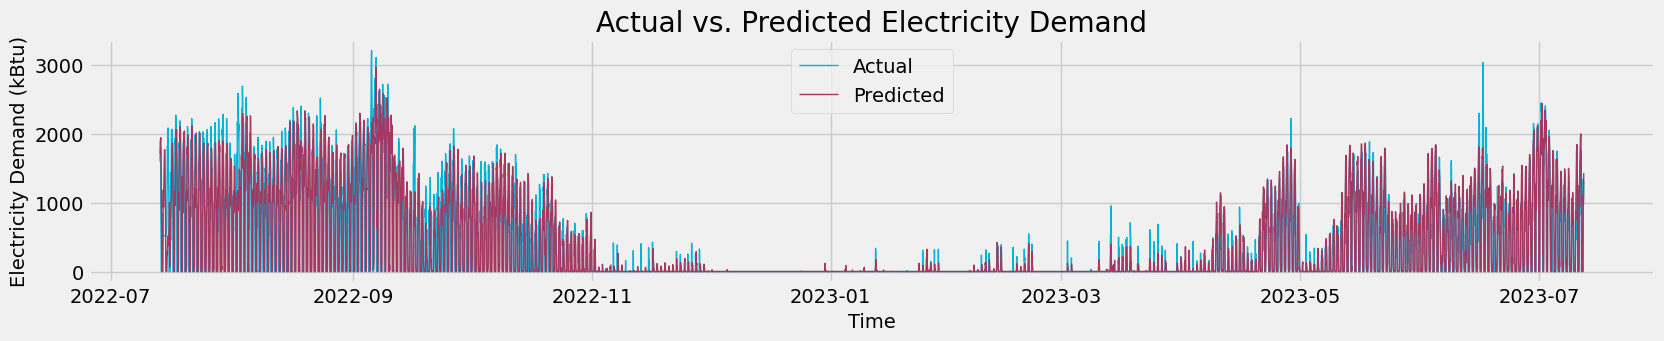

In [21]:

plt.figure(figsize=(18, 3))

#plt.plot(temp.index[-3000:], temp["ARCPavilion_Electricity_Demand_kBtu"].tail(3000), label="Actual", linewidth = 1, color = "#00b4d8")
#plt.plot(temp.index[-3000:], send_df["ARCPavilion_Baseline_Modeled_Electricity"].tail(3000), label="Predicted", linewidth=1, color="#a53860")

plt.plot(temp.index, temp["ARCPavilion_ChilledWater_Demand_kBtu"], label="Actual", linewidth = 1, color = "#00b4d8")
plt.plot(temp.index, send_df["ARCPavilion_Baseline_Modeled_ChilledWater"], label="Predicted", linewidth=1, color="#a53860")

plt.xlabel("Time")
plt.ylabel("Electricity Demand (kBtu)")
plt.title("Actual vs. Predicted Electricity Demand")

plt.legend()

plt.show()


In [24]:
# plt.figure(figsize=(18, 3))

# #plt.plot(temp.index[-3000:], temp["ARC_Electricity_Demand_kBtu"].tail(3000), label="Actual", linewidth = 1, color = "#00b4d8")
# #plt.plot(temp.index[-3000:], send_df["ARC_Baseline_Modeled_Electricity"].tail(3000), label="Predicted", linewidth=1, color="#a53860")

# plt.plot(temp.index, temp["Asmundson_ChilledWater_Demand_kBtu"], label="Actual", linewidth = 1, color = "#00b4d8")
# plt.plot(temp.index, send_df["Asmundson_Baseline_Modeled_ChilledWater"], label="Predicted", linewidth=1, color="#a53860")

# plt.xlabel("Time")
# plt.ylabel("Electricity Demand (kBtu)")
# plt.title("Actual vs. Predicted Electricity Demand")

# plt.legend()

# plt.show()

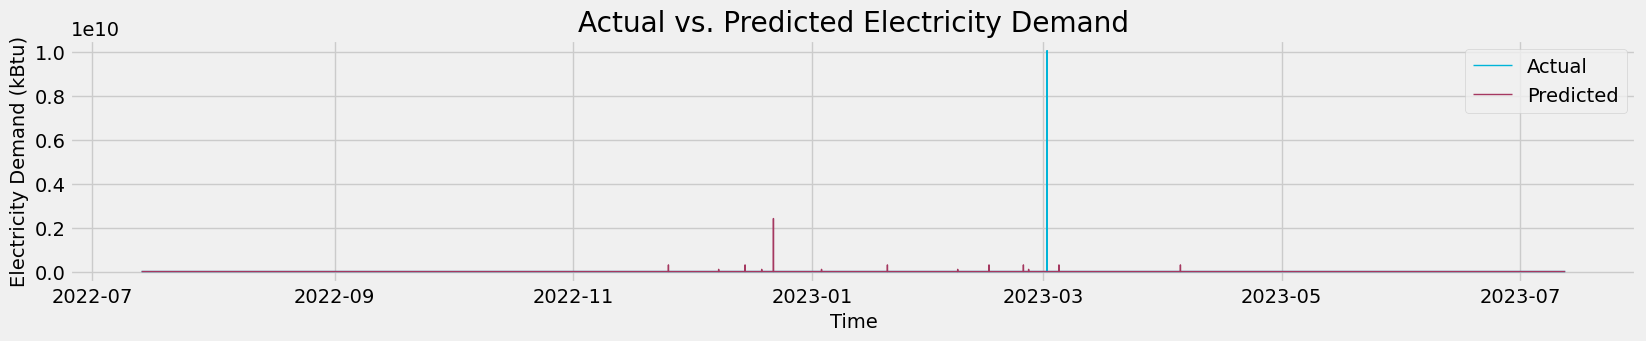

In [23]:
plt.figure(figsize=(18, 3))

plt.plot(temp.index, temp["AcademicSurge_ChilledWater_Demand_kBtu"], label="Actual", linewidth = 1, color = "#00b4d8")
plt.plot(temp.index, send_df["AcademicSurge_Baseline_Modeled_ChilledWater"], label="Predicted", linewidth=1, color="#a53860")

#plt.plot(temp.index[-1080:], temp["AcademicSurge_Electricity_Demand_kBtu"].tail(1080), label="Actual", linewidth = 1, color = "#00b4d8")
#plt.plot(temp.index[-1080:], send_df["AcademicSurge_Baseline_Modeled_Electricity"].tail(1080), label="Predicted", linewidth=1, color="#a53860")

plt.xlabel("Time")
plt.ylabel("Electricity Demand (kBtu)")
plt.title("Actual vs. Predicted Electricity Demand")

plt.legend()

plt.show()

0.05975806029155388
0.8566790851329901


<Figure size 640x480 with 0 Axes>

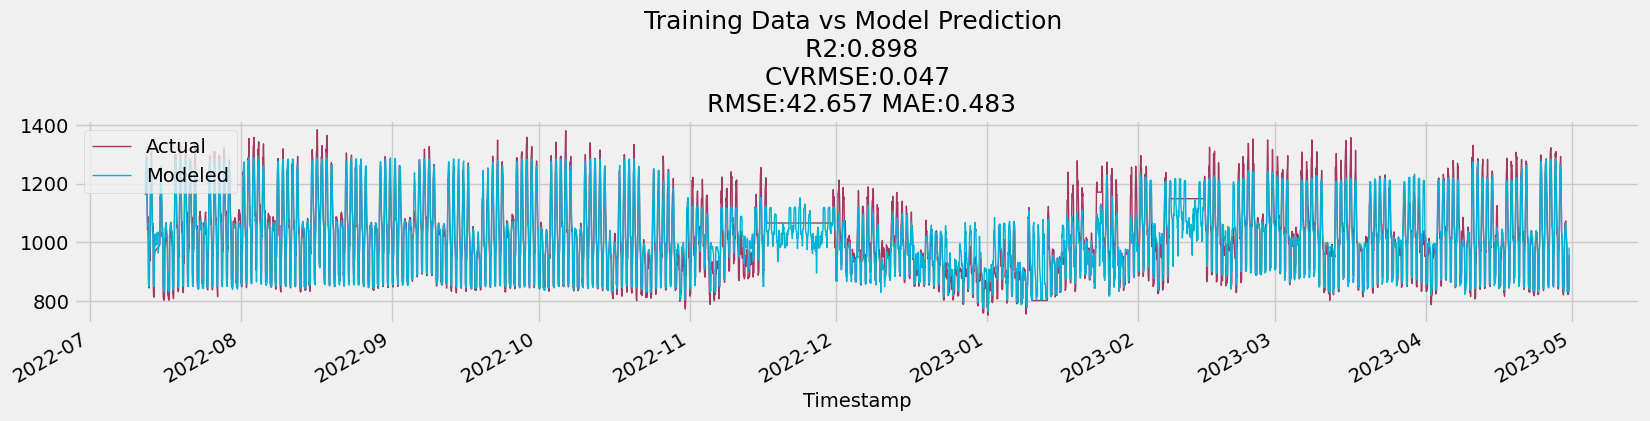

<Figure size 640x480 with 0 Axes>

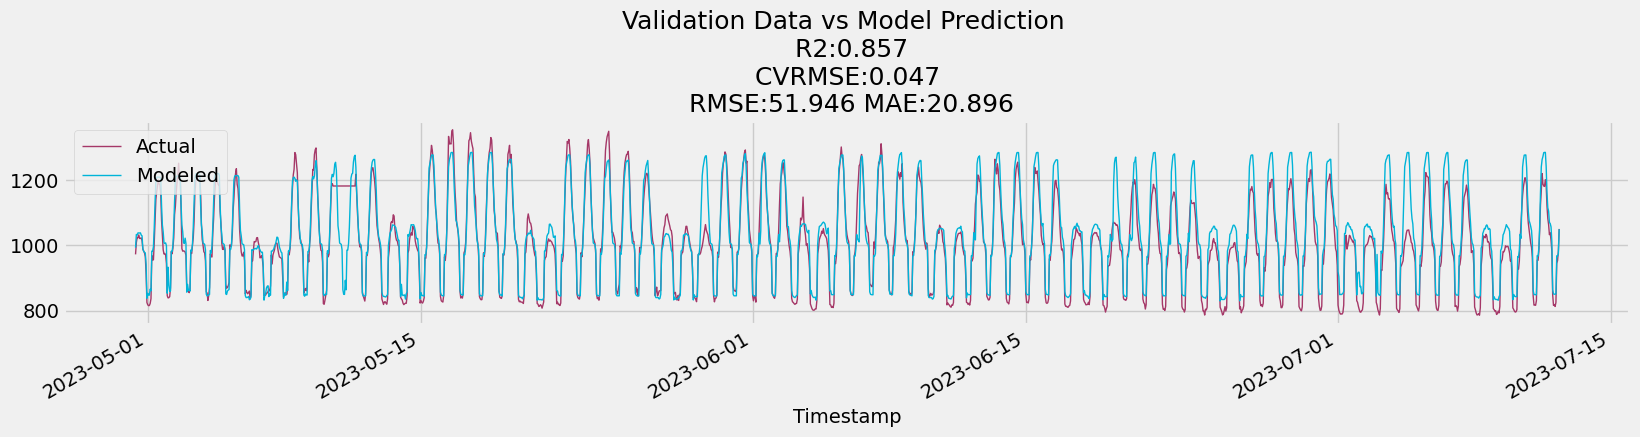

In [47]:
method = gs_gbt
X_train = X_train_scaled
X_val = X_val_scaled
y_train = y_train
y_val= y_val    
    #r2
r2_train = r2_score(y_train, method.predict(X_train))
r2_val = r2_score(y_val, method.predict(X_val))
    #rmse
rmse_train = math.sqrt(mean_squared_error(y_train, method.predict(X_train)))
rmse_val = math.sqrt(mean_squared_error(y_val, method.predict(X_val)))
    #mae
mae_train = np.median((method.predict(X_train) - y_train))
mae_val = np.median(method.predict(X_val) - y_val)
    #cvrmse
cvrmse_train = rmse_train/(np.max(method.predict(X_train))-np.min(method.predict(X_train))/2)
cvrmse_val = rmse_val/(np.max(method.predict(X_val))-np.min((method.predict(X_val))/2))

    #plot of Training Data vs Model Prediction
plt.figure()
training_comparison = pd.DataFrame({"Actual":y_train,
                                    "Modeled":method.predict(X_train)}, index=y_train.index)

training_comparison.sort_index().plot(figsize=(18,3),
                                      title="Training Data vs Model Prediction",
                                      linewidth=1,
                                      color=["#a53860","#00b4d8"])

plt.title(f'Training Data vs Model Prediction \n R2:{round(r2_train,3)}\n CVRMSE:{round(cvrmse_train,3)} \n RMSE:{round(rmse_train,3)} MAE:{round(mae_train,3)}',
          fontsize = 18)
plt.legend(prop={'size': 14},loc='upper left')


    #plot of Validation Data vs Model Prediction
plt.figure()
val_comparison = pd.DataFrame({"Actual":y_val,
                               "Modeled":method.predict(X_val)}, index=y_val.index)
    
    ## set then negative values to 0 only in Validation set.
val_comparison.loc[val_comparison.iloc[:,1]<0] = 0
    
val_comparison.sort_index().plot(figsize=(18,3),
                                 title="Validation Data vs Model Prediction",
                                 linewidth=1,
                                 color= ["#a53868","#00b4d8"])

plt.title(f'Validation Data vs Model Prediction \n R2:{round(r2_val,3)}\n CVRMSE:{round(cvrmse_train,3)} \n RMSE:{round(rmse_val,3)} MAE:{round(mae_val,3)}',
          fontsize = 18)
plt.legend(prop={'size': 14},loc='upper left')    
    
print(cvrmse_val)
print(r2_val)
        # print() 
        # print(round(cvrmse_val,2), round(r2_val,2))
        # print()



In [695]:
pred_start = pd.to_datetime(datetime.now().strftime('%Y-%m-%d %H:00:00')) - timedelta(days=365)
pred_end = datetime.now().strftime('%Y-%m-%d %H:00:00')
calc = "summary"
x_predict = pc.get_stream_by_point('aiTIT4045',  start = pred_start,
                                   end = pred_end, calculation=calc, 
                                   interval=interval, _chunk_size=chunk_size)
x_predict.rename(columns = {'aiTIT4045':'Temp'}, inplace=True)
x_predict['cdd'] = 0
x_predict.loc[x_predict.Temp > 65, 'cdd'] = x_predict.loc[x_predict.Temp > 65, 'Temp'] - 65
x_predict['hdd'] = 0
x_predict.loc[x_predict.Temp < 65, 'hdd'] = 65 - x_predict.loc[x_predict.Temp < 65, 'Temp']
x_predict['cdd2'] = x_predict.cdd**2
x_predict['hdd2'] = x_predict.hdd**2
x_predict["Hour"] = x_predict.index.hour
x_predict["Month"] = x_predict.index.month
x_predict["DOW"] = x_predict.index.dayofweek
x_predict['covid'] = 0
x_predict.loc["2020-03-17":"2021-09-28", 'covid'] = 1
x_predict = x_predict.dropna()
x_predict_scaled = scaler.transform(x_predict)

        # final check
    #     df_check = pc.get_stream_by_point(data_name, start=pred_start, 
    #                                            end=pred_end, calculation=calculation,
    #                                            interval=interval, 
    #                                           _chunk_size=chunk_size)

    #     # checking cvrmse and r2
if cvrmse_val > 0.5:
    pred = np.nan
    pd.DataFrame(pred, index=x_predict.index, columns = [data])

else:
    pred = gs_gbt.predict(x_predict_scaled)

            # plotcheck
    plt.figure()
    #         prediction_comparison = pd.DataFrame({"Actual":df_check[data_name],
    #                                             "Modeled":pred}, index=df_check.index)

    #         prediction_comparison.sort_index().plot(figsize=(18,3),
    #                                               title="Training Data vs Model Prediction",
    #                                               linewidth=1,
    #                                               color=["#a53860","#00b4d8"])

    #         plt.title(f'Acutual Data vs Model Prediction \n R2:{round(r2_val,3)}\n CVRMSE:{round(cvrmse_val,3)}',
    #                   fontsize = 18)
    #         plt.legend(prop={'size': 14},loc='upper left')
    #         #############################
    pd.DataFrame(pred, index=x_predict.index, columns = [data])

14:33:47: Sending API request... Chunk 1 of 1
14:33:49: Response recieved for 1 tags! (1.39)


<Figure size 640x480 with 0 Axes>